### Importing Libraries for our Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse
from plotnine import ggplot, aes, geom_point, geom_smooth, labs, ggtitle, ylim, theme, element_blank, element_text
from plotnine import ggplot, aes, geom_histogram, coord_cartesian,labs, theme_bw, expand_limits, scale_y_continuous, scale_x_continuous

### Importing data from the URL

In [2]:
data = pd.read_csv('https://osf.io/4ay9x/download')

In [3]:
data.head()

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
1,5,75680310997590,January,AL,3457.1138,450.00,40,41,2,NaN,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent
2,6,75680310997590,January,AL,3936.9110,1090.00,60,41,2,NaN,...,2,6,"Native, Born In US",63,Motor vehicles and motor vehicle equipment man...,8140,"Private, For Profit",No,No,Employed-At Work
3,10,179140131100930,January,AL,3288.3640,769.23,40,40,1,NaN,...,2,4,"Native, Born In US",63,"**Publishing, except newspapers and software (...",8255,"Private, For Profit",Yes,NaN,Employed-At Work
4,11,179140131100930,January,AL,3422.8500,826.92,40,43,1,NaN,...,2,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149316 entries, 0 to 149315
Data columns (total 23 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  149316 non-null  int64  
 1   hhid        149316 non-null  int64  
 2   intmonth    149316 non-null  object 
 3   stfips      149316 non-null  object 
 4   weight      149316 non-null  float64
 5   earnwke     149316 non-null  float64
 6   uhours      149316 non-null  int64  
 7   grade92     149316 non-null  int64  
 8   race        149316 non-null  int64  
 9   ethnic      20071 non-null   float64
 10  age         149316 non-null  int64  
 11  sex         149316 non-null  int64  
 12  marital     149316 non-null  int64  
 13  ownchild    149316 non-null  int64  
 14  chldpres    149316 non-null  int64  
 15  prcitshp    149316 non-null  object 
 16  state       149316 non-null  object 
 17  ind02       149316 non-null  object 
 18  occ2012     149316 non-null  int64  
 19  cl

In [5]:
data.shape

(149316, 23)

### Filtering the data to the requirements of our analysis

In [6]:
data = data[(data["occ2012"] == 630) & (data["age"] > 20)]

In [7]:
# Checking the count for occupations
data.groupby("occ2012").size().reset_index(name='count')

,occ2012,count
0,630,699


### Time to create new variables for earnings per hour and it's log

In [8]:
data["male"] = np.where(data["sex"] == 1, 1, 0)
data['wages'] = data['earnwke'] / data['uhours']
data['lnwages'] = np.log(data['wages'])
data = data[data['grade92'] >= 38]
data = data[data['wages'] > 1]

### Creating dummy variables for Education

In [9]:
educational_variables = [
    (data['grade92'].isin([41, 42])),  
    (data['grade92'] == 43),  
    (data['grade92'] == 44),  
    (data['grade92'] == 45),  
    (data['grade92'] == 46) ]

education_categories = ['Associate', 'Bachelors', 'Masters', 'Professional', 'PhD']

data['education'] = np.select(educational_variables, education_categories, default=None)


In [10]:
data['agesq'] = data['age'] ** 2
data['child'] = np.where(data['ownchild'] >= 1, 1, 0)
data['race_white'] = np.where(data['race'] == 1, "white", "other")
data['white'] = np.where(data['race_white'] == "white", 1, 0)
data['marital_status'] = np.where(data['marital'] <= 3, 1, 0)

In [11]:
filtered_data = data[data['wages'] >= 1]
summary_data = filtered_data[['earnwke', 'uhours', 'wages']].describe()

print(summary_data)

           earnwke      uhours       wages
count   694.000000  694.000000  694.000000
mean   1116.531585   40.881844   27.046610
std     603.588176    7.407955   13.568524
min      75.000000    6.000000    2.307600
25%     701.600000   40.000000   17.322500
50%     961.530000   40.000000   23.798000
75%    1402.250000   40.000000   34.497000
max    2884.610000   65.000000   85.256333


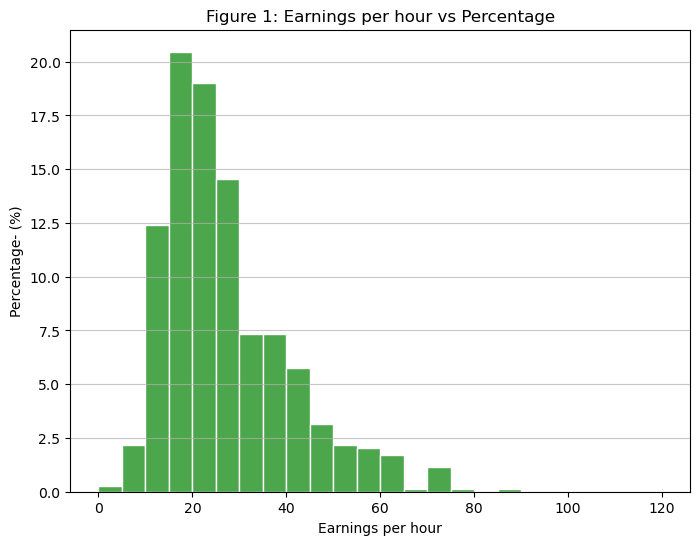

In [12]:
plt.figure(figsize=(8, 6))
sns.histplot(data['wages'], 
             bins=range(0, 121, 5), 
             stat="percent",
             color="green",
             edgecolor="white",
             alpha=0.7)

# Setting plot labels and title
plt.xlabel("Earnings per hour")
plt.ylabel("Percentage- (%)")
plt.title("Figure 1: Earnings per hour vs Percentage")

# Adjusting the axis and grid
plt.grid(axis='y', alpha=0.7)
plt.show()


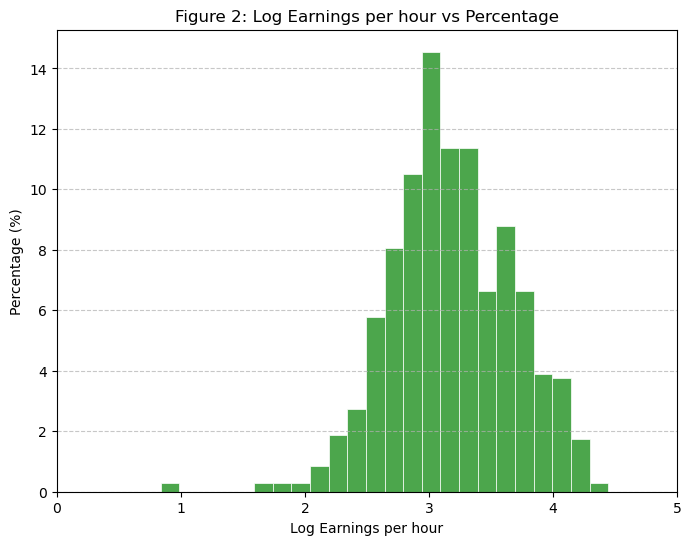

In [13]:
plt.figure(figsize=(8, 6))
sns.histplot(data['lnwages'], 
             stat="percent", 
             color="green", 
             edgecolor="white",
             alpha=0.7, 
             linewidth=0.5)
plt.xlabel("Log Earnings per hour")
plt.ylabel("Percentage (%)")
plt.title("Figure 2: Log Earnings per hour vs Percentage")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xlim(0, 5)
plt.show()


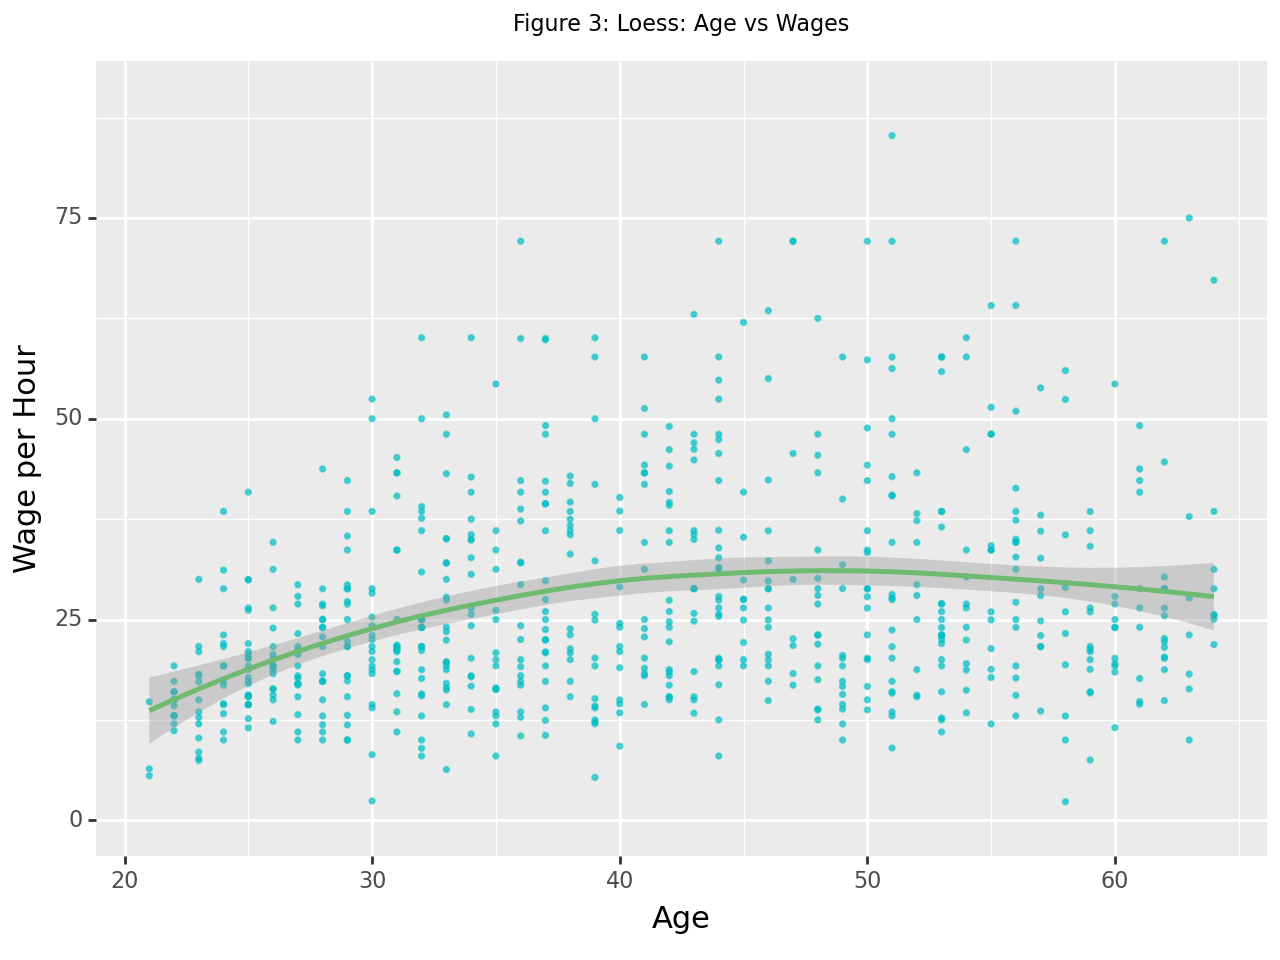

In [14]:
loess = (
    ggplot(data, aes(x='age', y='wages')) +
    geom_point(size=0.5,
               alpha=0.6,
               color="#00BFC4") +
    geom_smooth(method='loess', 
               color='#6DBA70') +
    labs(x='Age', 
         y='Wage per Hour') +
    ggtitle('Figure 3: Loess: Age vs Wages') +
    ylim(0, 90) +
    theme(
        panel_border=element_blank(),
        axis_text=element_text(size=8),
        plot_title=element_text(size=8,
                                hjust=0.5)
    )
)

print(loess)


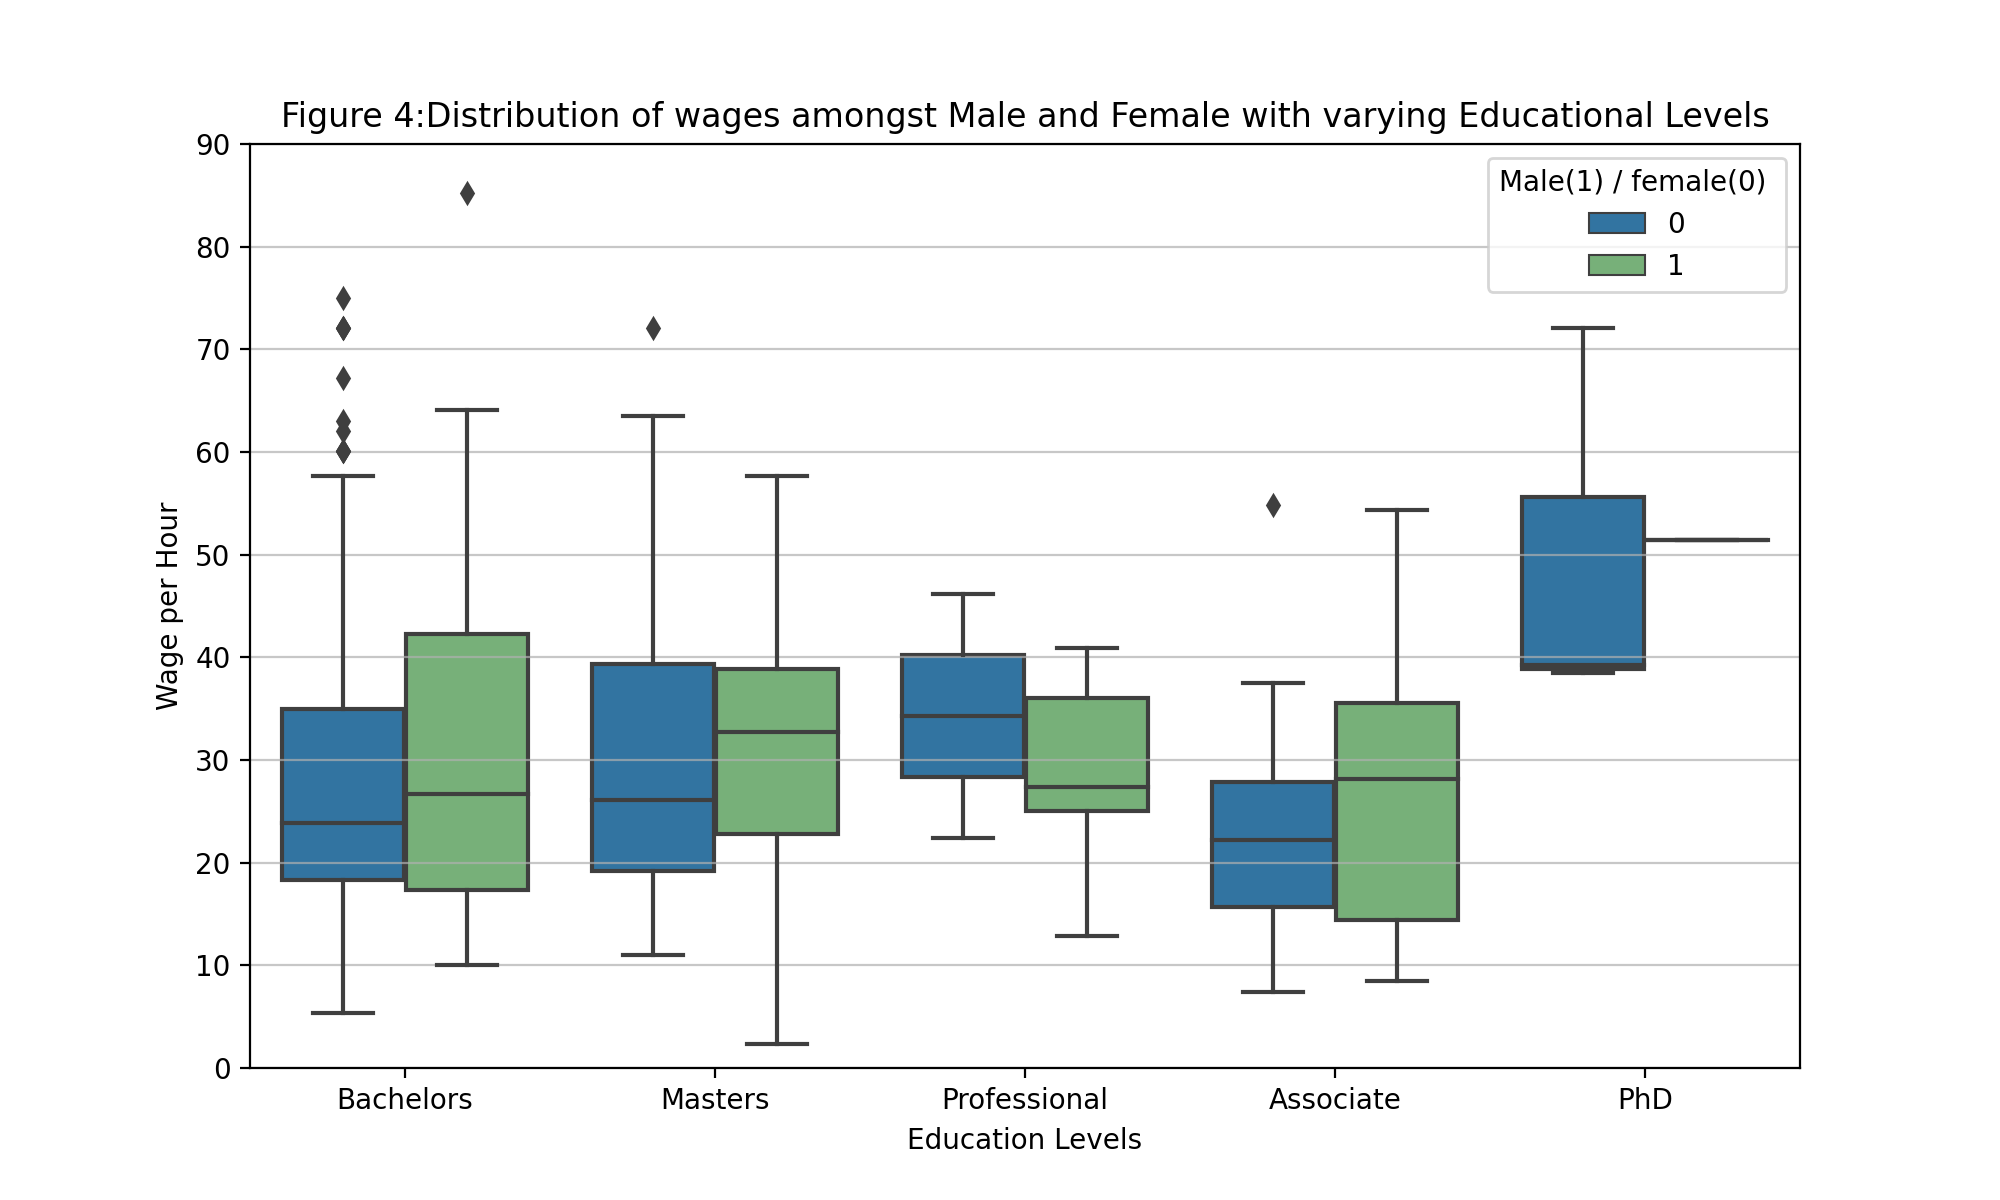

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='education', 
            y='wages', 
            hue='male', 
            data=data, 
            palette=['#1f78b4', '#6DBA70'], 
            width=0.8)

# Setting plot labels and title
plt.xlabel("Education Levels")
plt.ylabel("Wage per Hour")
plt.ylim(0, 90)

plt.grid(axis='y',  alpha=0.7)
plt.legend(title="Male(1) / female(0) ", loc='upper right')

plt.title("Figure 4:Distribution of wages amongst Male and Female with varying Educational Levels", fontsize=12, fontweight='light')
plt.show()


In [17]:
# Create binary columns for each education level
data['Associate'] = data['education'] == 'Associate'
data['Bachelors'] = data['education'] == 'Bachelors'
data['Masters'] = data['education'] == 'Masters'
data['Professional'] = data['education'] == 'Professional'
data['PhD'] = data['education'] == 'PhD'

# Fit the model
reg1 = sm.OLS(data['wages'], data[['Associate', 'Bachelors', 'Masters', 'Professional', 'PhD']]).fit(cov_type="HC0")

# Display the results
print(reg1.summary())


                                 OLS Regression Results                                
Dep. Variable:                  wages   R-squared (uncentered):                   0.635
Model:                            OLS   Adj. R-squared (uncentered):              0.632
Method:                 Least Squares   F-statistic:                              434.8
Date:                Mon, 22 Jan 2024   Prob (F-statistic):                   2.53e-210
Time:                        01:25:17   Log-Likelihood:                         -3001.3
No. Observations:                 694   AIC:                                      6013.
Df Residuals:                     689   BIC:                                      6035.
Df Model:                           5                                                  
Covariance Type:                  HC0                                                  
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

### Creating models for Regression Analysis

In [18]:
model1 = smf.ols(formula='wages ~ Associate + Bachelors + Masters + Professional + PhD', data=data)
reg1 = model1.fit()

model2 = smf.ols(formula='wages ~ Associate + Bachelors + Masters + Professional + PhD + age + agesq + male', data=data)
reg2 = model2.fit()

model3 = smf.ols(formula='wages ~ Associate + Bachelors + Masters + Professional + PhD + male + age + agesq + white + child + marital_status', data=data)
reg3 = model3.fit()

model4 = smf.ols(formula='wages ~ Associate + Bachelors + Masters + Professional + PhD + male + age + agesq + white + child + marital_status + marital_status*male + male*Associate + male*Bachelors + male*Masters + male*Professional + male*PhD + male*child + age*child', data=data)
reg4 = model4.fit()


In [19]:
type(reg1)
type(reg2)
type(reg3)
type(reg4)

statsmodels.regression.linear_model.RegressionResultsWrapper

In [20]:
print(reg1.get_robustcov_results(cov_type='HC1').summary())

                            OLS Regression Results                            
Dep. Variable:                  wages   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     9.568
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           7.71e-09
Time:                        01:25:23   Log-Likelihood:                -2771.7
No. Observations:                 694   AIC:                             5555.
Df Residuals:                     688   BIC:                             5583.
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               23.3977 

In [21]:
reg1.bic

5582.642331430474

#### After looking at the results from Model 1, we will be expanding the variables and gather results for the other models. The variables will be increased with each model adding complexity to it. 

In [22]:
models = [reg1, reg2, reg3, reg4]
robustcov_results=[]

for i, model in enumerate(models):
    result=model.get_robustcov_results(cov_type='HC1').summary()
    robustcov_results.append(result)
    print()
    print(f'Regression: reg{i+1}')
    print(result)


Regression: reg1
                            OLS Regression Results                            
Dep. Variable:                  wages   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     9.568
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           7.71e-09
Time:                        01:25:25   Log-Likelihood:                -2771.7
No. Observations:                 694   AIC:                             5555.
Df Residuals:                     688   BIC:                             5583.
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept     

In [23]:
from sklearn.model_selection import KFold
k = KFold(n_splits=4, shuffle=False, random_state=None)

#### Now we will cross validate OLS  by using statsmodels OLS formula along with sklearn k-fold cross validation. In this, we will be calculating the OLS for each fold specifically and check the statistics for each of our 4 folds.

In [24]:
### Cross validate OLS with combining sklearn k-fold cross validation and statsmodels ols formula


def cv_reg(formula, data, kfold, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(data):
        # print("TRAIN:", train_index, "TEST:", test_index)
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]
        rmse_list += [rmse(data_train[formula.split("~")[0]], model.predict())]

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cv_list))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [25]:
cv1 = cv_reg('wages~ Associate + Bachelors + Masters + Professional + PhD', data, k, "HC0")
cv2 = cv_reg('wages~ Associate + Bachelors + Masters + Professional + PhD + age + agesq + male', data, k, "HC0")
cv3 = cv_reg(
    'wages~ Associate + Bachelors + Masters + Professional + PhD + male + age + agesq + white + child + marital_status',
    data,
    k,
    "HC0",
)

cv4 = cv_reg(
    'wages~ Associate + Bachelors + Masters + Professional + PhD + male + age + agesq + white + child + marital_status + marital_status*male + male*Associate + male*Bachelors + male*Masters + male*Professional + male*PhD + male*child + age*child',
    data,
    k,
    "HC0",
)
cv_list = [cv1, cv2, cv3, cv4]


In [26]:
summarize_cv(cv_list)

,Model1,Model2,Model3,Model4
Fold1,12.919500,11.877732,11.784141,11.627399
Fold2,13.160009,12.103995,11.996320,11.799814
Fold3,13.187572,12.093038,12.051339,11.827412
Fold4,13.193208,11.915244,11.806503,11.687276
Average,13.115072,11.997502,11.909576,11.735475


In [27]:
reg1.resid.describe()

count    6.940000e+02
mean    -8.026880e-15
std      1.313890e+01
min     -2.861617e+01
25%     -9.475277e+00
50%     -3.222659e+00
75%      6.143493e+00
max      5.655481e+01
dtype: float64

In [28]:
p1=reg1.get_prediction(data).summary_frame()
p1

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,28.701527,0.750157,27.228655,30.174399,2.768938,54.634115
1,23.397659,0.920989,21.589372,25.205946,-2.556140,49.351458
2,28.701527,0.750157,27.228655,30.174399,2.768938,54.634115
3,23.397659,0.920989,21.589372,25.205946,-2.556140,49.351458
4,30.923767,1.367382,28.239023,33.608510,4.894214,56.953320
...,...,...,...,...,...,...
689,28.701527,0.750157,27.228655,30.174399,2.768938,54.634115
690,23.397659,0.920989,21.589372,25.205946,-2.556140,49.351458
691,23.397659,0.920989,21.589372,25.205946,-2.556140,49.351458
692,30.923767,1.367382,28.239023,33.608510,4.894214,56.953320


In [29]:
(reg3.fittedvalues-data.wages).describe()

count    6.940000e+02
mean     1.345895e-12
std      1.194939e+01
min     -4.728024e+01
25%     -5.668299e+00
50%      2.046469e+00
75%      7.726027e+00
max      3.500005e+01
dtype: float64

In [30]:
p2=reg3.get_prediction(data).summary_frame()
p2

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,23.560929,0.993081,21.611066,25.510792,-0.169786,47.291644
1,27.475077,1.161145,25.195229,29.754925,3.714973,51.235182
2,26.638480,1.067790,24.541930,28.735031,2.895263,50.381698
3,18.603473,1.454286,15.748058,21.458888,-5.218749,42.425695
4,31.195825,1.440548,28.367382,34.024267,7.376821,55.014829
...,...,...,...,...,...,...
689,17.008971,1.494601,14.074398,19.943544,-6.822869,40.840810
690,26.363465,1.192979,24.021112,28.705819,2.597282,50.129649
691,18.625009,1.214068,16.241250,21.008768,-5.145292,42.395309
692,37.307645,1.972029,33.435669,41.179622,13.342315,61.272976


In [31]:
rmse(reg3.fittedvalues,data.wages)

11.940782084401246

In [32]:
pd.DataFrame(
    {
        " ": ["Predicted", "PI_low(95%)", "PI_high(95%)"],
        "Model1": p1[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model3": p2[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
    }
).set_index(" ")

,Model1,Model3
,,
Predicted,28.701527,23.560929
PI_low(95%),2.768938,-0.169786
PI_high(95%),54.634115,47.291644


In [33]:
# summary of predictions and PI 80% version
p1=reg1.get_prediction(data).summary_frame(alpha=0.2)
p2=reg3.get_prediction(data).summary_frame(alpha=0.2)

pd.DataFrame(
    {
        " ": ["Predicted", "PI_low(80%)", "PI_high(80%)"],
        "Model1": p1[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model3": p2[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
    }
).set_index(" ")

,Model1,Model3
,,
Predicted,28.701527,23.560929
PI_low(80%),11.758680,8.056768
PI_high(80%),45.644373,39.065090
